<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/testing/CBF/boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Control of DC-DC buck converter.
Objectives
- Transient voltage should be with in the bounds.
\begin{align}
\underline V \leq V(t) \leq \overline V
\end{align}

Remarks:
- We use control barrier functions
- Method 1 does not work
- Method 2 works

In [2]:
import numpy as np
import gym
from gym import spaces

import matplotlib.pyplot as plt

#Physical Model
The dynamics of the Buck converter are:
\begin{align}
-L\dot{I} &= RI+(1-u)V-V_s\\
C\dot{V} &= (1-u)I-GV
\end{align}


> ![alt text](https://i.imgur.com/AdJlqEN.png)







The parameters are:


*   L - Inductance
*   C - Capacitance
*   R - Series Resistance
*   G - Load Impedance
*   $V_s$ - Source Voltage

The state variables:
*  $I\geq 0$ - current through the inductor
*  $V\geq 0$ - voltage across the Capacitor

Input:
* $u\in (0,1)$ - duty-ratio

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d > V_s$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - (V-V_d)^2 
\end{align}




In [3]:
#@title ##Parameters

#@markdown ---

#@markdown ###System Parameters (Units in 1e-3).
Capacitance = 1 #@param {type:"slider", min:1, max:100, step:0.1}
Inductance = 1 #@param {type:"slider", min:1, max:100, step:0.1}

Resistance = 0 #@param {type:"slider", min:0, max:100, step:0.1}
load = 38.8 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown Voltage Source.
Vs = 200 #@param {type:"slider", min:100, max:500, step:10}

#@markdown Desired Voltage.
Vd = 380 #@param {type:"slider", min: 100, max:500, step:10}


C = Capacitance*1e-3
L = Inductance*1e-3
R = Resistance*1e-3
G = load*1e-3


##Equilibrium points
\begin{align}
RI_d+(1-u_d)V_d-V_s =0\\
(1-u_d)I_d-GV_d =0
\end{align}

\begin{align}
&RI_d+(1-u_d)V_d-V_s =0\\
&R(1-u_d)I_d+(1-u_d)^2V_d-(1-u_d)V_s =0\\
&RGV_d+(1-u_d)^2V_d-(1-u_d)V_s = 0
\end{align}
Denote $\mu = 1-u_d$, then we solve $\mu_d$ using
\begin{align}
&\mu^2V_d-\mu V_s + RGV_d= 0
\end{align}

In [4]:
import numpy as np

def Boost_equlibrium(V_s = 300, R = 0.001, G = 0.04, Vdes = 380):
    a = Vdes
    b = -V_s
    c = R*G*Vdes

    # calculate the discriminant
    d = (b**2) - (4*a*c)
    if d<0:
        raise ValueError("Non feasible equlibrium")
    else:
        #sol1 = (-b-cmath.sqrt(d))/(2*a)
        sol2 = (-b+np.sqrt(d))/(2*a)
    if (sol2<=1) & (sol2>=0):
        duty_ratio = 1- sol2 
    else:
        raise ValueError("Non feasible equlibrium")
    return Vdes, G*Vdes/sol2, duty_ratio
    #A = np.array([[R, sol2],[sol2, -G]])

Boost_equlibrium(V_s = 300, R = 0.001, G = 0.04, Vdes = 380)


(380, 19.2545691281077, 0.2105769857082319)

# Gym Model

In [9]:
class Boost_Converter_n(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, Vs = 300, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5):
        super(Boost_Converter_n, self).__init__()

        #parameters
        self.Vs = Vs
        self.L = L
        self.C = C
        self.R = R
        self.G = G

        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-5
        self.T = dt

        #the steady-state equilibrium of the system is
        self.Vdes = Vdes
        _, self.Ides, self.udes = self.equlibrium()
        if self.Vs > self.Vdes:
            raise ValueError("for Boost converter desired voltage should be Greater the source Voltage")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf]), high=np.array([+np.inf, +np.inf]), shape=None, dtype=np.float32)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = self.Ides#np.random.uniform(low = self.Ides, high = self.Ides)
        V = self.Vdes#np.random.uniform(low = self.Vdes, high = self.Vdes)
        self.state = np.array([I, V])

    def _set_state(self, I, V):
        #using this function we can change the state variable
        self.state = np.array([I, V])

    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Vdes, self.udes])

    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):

        u = np.clip(action, 0, 1)

        i = self.state[0]
        v = self.state[1]

        didt = (-1.0/self.L)*(self.R*i + (1-u)*v - self.Vs)
        dvdt = (1.0/self.C)*((1-u)*i - self.G*v)

        new_i = i + self.T * didt
        new_v = v + self.T * dvdt

        self.state = np.array([new_i, new_v]).astype(np.float32)

        # normalize the rewards
        reward = -((new_v-self.Vdes))**2
        done = False
        return self.state, reward, done, {}

    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0] - self.Ides
        ev = self.state[1] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, V-Vdes = {:.2f}".format(ei, ev))

    def close(self):
        pass
    def equlibrium(self):
        a = self.Vdes
        b = -self.Vs
        c = self.R*self.G*self.Vdes

        # calculate the discriminant
        d = (b**2) - (4*a*c)
        if d<0:
            raise ValueError("Non feasible equlibrium")
        else:
            #sol1 = (-b-cmath.sqrt(d))/(2*a)
            sol2 = (-b+np.sqrt(d))/(2*a)
        if (sol2<=1) & (sol2>=0):
            duty_ratio = 1- sol2 
        else:
            raise ValueError("Non feasible equlibrium")
        return self.Vdes, G*self.Vdes/sol2, duty_ratio
        #A = np.array([[R, sol2],[sol2, -G]])

# Testing

In [6]:
def plot_signals(data, Ides, Vdes, dt = 1e-5):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(0, des[i]+50)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()
def plot_signals_1(data, Ides, Vdes, dt = 1e-5, dv = 1, bounds = 5):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i] - dv), marker = '.')
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i] + dv), marker = '.')
        ax[i].set_ylim(des[i]-bounds, des[i]+bounds)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()  

## Constant input policy

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


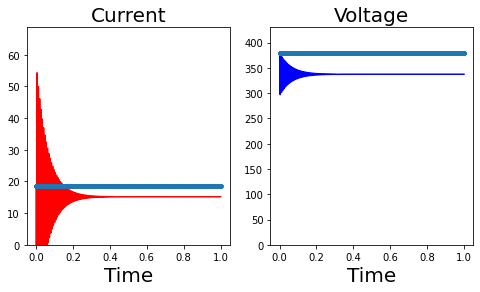

In [7]:
env = Boost_Converter_n()

env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(env.udes - 0.1)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

## Stabilizing  input policy

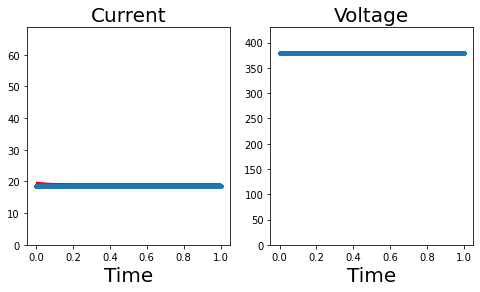

In [10]:
env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(env.udes)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

#CBF
Consider the following function
\begin{align*}
b_1 &= V-\underline V\\
b_2 &= \overline V - V
\end{align*}

\begin{align*}
    H_1&= C\dot V +\eta_a (V-\underline V) \geq 0\\
    &= (1-u)I-GV + \eta_a (V-\underline V) \geq 0\\
    H_2&=-C\dot V  +  \eta_b (\overline V - V) \geq 0\\
    &=-(1-u)I+GV +  \eta_b (\overline V - V) \geq 0
\end{align*}
Choosing $\eta_a,~\eta_b =G$, we arrive at
\begin{align*}
    H_1&= (1-u)I-G\underline V  \geq 0\\
    &\implies -I u \geq G\underline V - I\\
    H_2&=-(1-u)I+G\overline V \geq 0\\
    &\implies I u \geq I - G\overline V
\end{align*}

\begin{equation}
\hspace{0.25cm} 
\begin{aligned}
& \underset{u, \epsilon \in \mathbb{R}^n}{\text{argmin}}   ~~~~(1/2)\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix}^\top \underbrace{\begin{bmatrix} 0&0&0\\0& 10^{24}&0\\0&0&10^{24} \end{bmatrix}}_P\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix} &&\\
& \text{subject to} & &\\
&   \underbrace{-\begin{bmatrix} 
-I&1 &0\\
I& 0&1 \\
1 &0 &0\\
-1 & 0&0
\end{bmatrix}}_{G}
\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix}
\leq
\underbrace{-
    \begin{bmatrix}
    G\underline V - I\\
    I - G\overline V\\
    0\\
    -1
    \end{bmatrix}}_{h} & &
\end{aligned}
\end{equation} 

In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 16 14:17:49 2018

@author: rcheng
"""

import numpy as np
from cvxopt import matrix
from cvxopt import solvers

#Build barrier function model
def cbf_2(env, eta_1 = 0., eta_2 = 0., dV = 1, G_diss = 0.0):
    eta_1 = 0.5 
    eta_2 = 0.5
    V_l  = env.Vdes - dV
    V_h = env.Vdes + dV
    N = 1
    P = matrix(np.diag([0.0, 1e24, 1e24]), tc='d')
    q = matrix(np.zeros(3))
    delta = env.T

    I = env.state[0]
    V = env.state[1]

    c_l =  ((env.G) * V_l/(I + 0.01) - 1) - eta_1*(V - V_l)
    c_h = (1 - (env.G) * V_h/(I + 0.01)) - eta_2 * (V_h - V)
    #print(c)

    G = -np.array([[-1, 1, 0], [1, 0, 1], [1, 0, 0], [-1, 0, 0]])
    G = matrix(G,tc='d')

    h = -np.array([c_l, c_h, 0, -1])
    #print(h)
    h = np.squeeze(h).astype(np.double)
    h = matrix(h,tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h)

    u_bar = sol['x']
    if np.abs(u_bar[1]) > 0.001:
        print("Violation of Safety: ")
        print(u_bar[1])
    return u_bar[0]






In [46]:
env = Boost_Converter_n()

env.reset()
print(env.state)
obs = []
N_steps = 10**5
G_diss = 0
for i in range(2000):
    u = cbf_2(env, eta_1 = 0, eta_2 = 0, dV =  15)
    print('input: {}'.format(u))
    env.step(u)
for i in range(N_steps):
    if i%10000 == 0:
        #env.G = env.G+G_diss
        print('step: ', i)
    #print('input: {}'.format(cbf_2(env)))
    u = cbf_2(env, eta_1 = 0, eta_2 = 0, dV =  50)
    s, r, _, _ = env.step(u)
    #print(u)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((N_steps ,env.observation_space.shape[0]))
plot_signals_1(trajectory, env.Ides, env.Vdes, dt = 1e-5, dv = 5)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ 18.67693205 380.        ]
input: 0.343298676426362
input: 0.3466473359460579
input: 0.3503727914938409
input: 0.35449631853514935
input: 0.359035968286915
input: 0.3640143008289036
input: 0.3694358666648473
input: 0.375301713448232
input: 0.38162477089841734
input: 0.3884080330296593
input: 0.39564431629455593
input: 0.40333137092910837
input: 0.4114572555334669
input: 0.42000796423872744
input: 0.42897533371271646
input: 0.43833483449125576
input: 0.44807575997403376
input: 0.4581716219351782
input: 0.46860277415578483
input: 0.4793417148078704
input: 0.4903607599901536
input: 0.5016322028712134
input: 0.5131209924547856
input: 0.5247999700916042
input: 0.5366349033351564
input: 0.548592105473934
input: 0.5606385205167779
input: 0.5727417584445995
input: 0.5848625430195165
input: 0.5969622130588342
input: 0.6090103772165998
input: 0.6209697463654251
input: 0.6328112340797191
input: 0.6444987775006862
input: 0.6560044315442219
input: 0.6672931400553159
input: 0.6783454895936496
input

KeyboardInterrupt: ignored

In [41]:
env.udes

0.2105769857082319

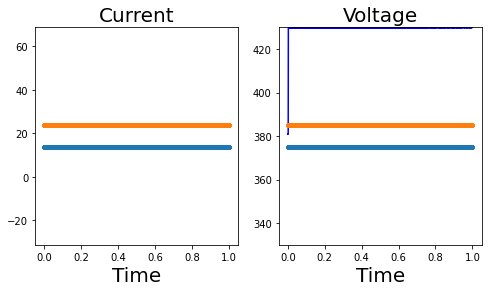

In [42]:
trajectory = np.concatenate(obs).reshape((N_steps ,env.observation_space.shape[0]))
plot_signals_1(trajectory, env.Ides, env.Vdes, dt = 1e-5, dv = 5, bounds = 50)

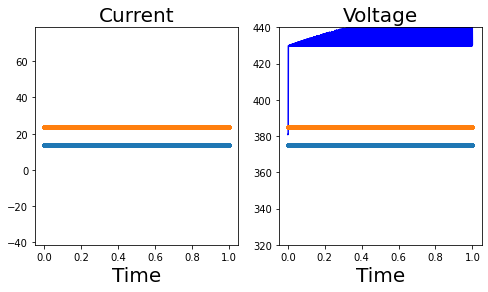

In [43]:
plot_signals_1(trajectory, env.Ides, env.Vdes, dt = 1e-5, dv = 5, bounds = 60)

#different Idea

\begin{align}
b &=VI_d-IV_d
\end{align}

\begin{align}
h &=\dot{V}I_d-\dot{I}V_d\\
&=
\end{align}